# DDO52 (SIDM FS LT)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
import math
import numdifftools as nd
import warnings
from IPython.display import display, Math
from scipy.integrate import odeint
from scipy.integrate import simps
from scipy.integrate import quad
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.stats import norm
import scipy.constants as sc
from scipy.special import iv, kv
from scipy.optimize import curve_fit

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#Membaca data kecepatan rotasi
gal = pd.read_excel('Galaksi LT.xlsx', sheet_name='Fisis')
df = pd.read_excel('Galaksi LT.xlsx', sheet_name='DDO52')
df

,ID,"R[""]",R[kpc],Vr[km/s],err_Vr,Va[km/s],err_Va,Vc[km/s],err_Vc,Vd[km/s],err_Vd,Sdens,err_Sdens
0,DDO52,9,0.45,11.76,3.14,0.02,0.09,11.76,3.14,6.88,1.91,3.18,0.52
1,DDO52,18,0.90,19.91,4.33,0.06,0.18,19.91,4.33,5.80,2.63,3.23,0.48
2,DDO52,27,1.35,28.53,3.02,0.12,0.28,28.53,3.02,5.87,1.80,2.89,0.67
3,DDO52,36,1.80,34.82,2.73,0.22,0.37,34.82,2.73,8.04,0.50,2.39,0.69
4,DDO52,45,2.25,37.06,3.47,0.41,0.60,37.07,3.47,8.01,0.57,2.19,0.59
5,DDO52,54,2.70,39.59,3.68,0.74,1.10,39.60,3.68,7.64,0.48,2.03,0.73
6,DDO52,63,3.15,43.36,3.26,1.37,2.03,43.39,3.26,8.00,0.54,2.09,0.69
7,DDO52,72,3.60,43.76,4.36,2.26,3.34,43.82,4.36,7.89,0.54,2.14,0.65
8,DDO52,81,4.04,47.29,4.39,3.64,4.66,47.43,4.40,8.09,0.64,2.04,0.68
9,DDO52,90,4.49,48.74,4.89,5.66,5.35,49.06,4.90,8.08,0.70,1.83,0.63


In [4]:
rad = df['R[kpc]'] #kpc
Vobs = df['Vc[km/s]'] #km/s
Vobs_err = df['err_Vc'] #km/s

item_index = gal[gal['ID'] == 'DDO52'].index[0]
r_star = gal.loc[item_index, 'rdisk']
r_gas = gal.loc[item_index, 'rgas']
M_disk_a = gal.loc[item_index, 'mdisk']
M_disk_u = gal.loc[item_index, 'mdisku']
M_disk_l = gal.loc[item_index, 'mdiskl']
M_gas = gal.loc[item_index, 'mgas']
r_eff = gal.loc[item_index, 'reff']

In [5]:
#MCMC
def main(p0, nwalkers, niter, ndim, ln_posterior, data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=data)

    print("Running burn-in...")
    p0 = sampler.run_mcmc(p0, 500, progress=True) #500 iterasi pertama ditetapkan sebagai burn-in
    sampler.reset() #reset sampler sebelum melakukan iterasi utama

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

In [6]:
#Stellar exponential disk
def Vdisk(r, M_disk, r_star):
    x = r/r_star
    I_0 = iv(0,1.6*x)
    I_1 = iv(1,1.6*x)
    K_0 = kv(0,1.6*x)
    K_1 = kv(1,1.6*x)
    G= 4.3e-6 # (km/s)**2 * kpc/Msun 
    V_D = np.sqrt(0.5*(G*(10**M_disk)/r_star))*((3.2*x)**2) * ((I_0*K_0)-(I_1*K_1))
    return V_D

#Gaseous exponential disk 
def Vgas(r, M_gas, r_gas):
    x = r/r_gas
    I_0 = iv(0,0.53*x)
    I_1 = iv(1,0.53*x)
    K_0 = kv(0,0.53*x)
    K_1 = kv(1,0.53*x)
    G= 4.3e-6 # (km/s)**2 * kpc/Msun
    V_gas = np.sqrt(0.5*(G*(10**M_gas)/r_gas))*((1.1*x)**2) * ((I_0*K_0)-(I_1*K_1))
    return V_gas

## Model Halo SIDM

In [7]:
G = 4.3009e-6 # kpc (km/s)^2 Msun^-1
#sigma_m = 50 # cm^2/g
t_age = 10 # Gyr

rmin = rad[rad.idxmin()]
rmax = rad[rad.idxmax()]

dr = 0.001
r = []
rf = [] # full dari 0
rr = np.arange(rmin/10, rmax*3, dr)
for i in range(len(rr)):
    r2 = round(rr[i], 3)
    r.append(r2)
rr = np.arange(0, rmax*3, dr)
for i in range(len(rr)):
    r2 = round(rr[i], 3)
    rf.append(r2)
r = np.array(r)
rf = np.array(rf)
xnew = r[int(np.where(r == rmin)[0]):int(np.where(r == rmax)[0])+1]

def lnrhoiso(p, ra, sigmav0, Mb, dMb, dMb_drmax):
    lnrho_iso, omega = p
    if ra < rmin:
        rho_b = Mb[0]/(4*math.pi*(rmin**3)/3)
    elif rmin <= ra <= rmax:
        rho_b = dMb(ra)/(4*math.pi*(ra**2))
    else:
        rho_b = float(dMb_drmax)/(4*math.pi*(rmax**2)) * (rmax/ra)**4
    dlnrhodr = [omega, -4*math.pi*G*(rho_b + np.exp(lnrho_iso))/(sigmav0**2) - 2*omega/ra]
    return dlnrhodr

def VSIDM(sigma_m, logGam0, sigmav0, Vdisk_func, Vgas_func, rad, returnfig):
    vdisk = Vdisk_func(rad)
    vgas = Vgas_func(rad)
    # Profil massa Baryon
    Mb = []
    for i in range(len(rad)):
        mb = max(0, ((vdisk[i]**2) + vgas[i]*np.abs(vgas[i]))*rad[i]/G)
        #mb = ((Vdisk_func(rad)[i]**2) + Vgas_func(rad)[i]*np.abs(Vgas_func(rad)[i]))*rad[i]/G  # Use Vdisk_func and Vgas_func
        Mb.append(mb)

    Mb_f = interp1d(rad, Mb, kind='quadratic', bounds_error=False, fill_value='extrapolate')
    dMb = nd.Derivative(Mb_f, n=1)
    dMb_dr = dMb(r)

    # Profil densitas inti isotermal
    dMb_drmax = dMb_dr[np.where(r == rmax)]
    rho_0 = (10**logGam0)*(3.086e+21**2)*3.086e+16*np.sqrt(math.pi)/(10**sigma_m*1.989e+33*4*sigmav0*3.1536e+16*10) # Msun/kpc^3
    p0 = [np.log(rho_0), 0.0]
    
    sol = odeint(lnrhoiso, p0, r, args=(sigmav0, Mb, dMb, dMb_drmax))
    rho_iso = np.exp(sol[:,0])

    # Densitas dan radius transisi
    rho_t = rho_0/(t_age * 10**logGam0 / 10)
    r1 = round(np.interp(rho_t, np.flip(rho_iso), np.flip(r)), 3) # kpc

    # Menghitung rs dan rho_s
    y_iso = []
    a = 0
    
    for i in range(len(rf)):
        if rf[i] < r[0]:
            yiso = rf[i]**2 * rho_iso[0]
            y_iso.append(yiso)
        elif r[0] <= rf[i] <= r1:
            yiso = rf[i]**2 * rho_iso[a]
            a += 1
            y_iso.append(yiso)
        else: # r[i] > r1
            break

    A_iso = simps(y_iso, rf[:int(np.where(rf == r1)[0])+1], even='avg')

    rs0 = 1.0 # initial
    drs = 1.0 # initial
    rs = 1.0 # initial
    rep = 0 # initial
    while drs > 0.001:
        rep += 1
        rs = r1/(np.exp(r1/(rs0+r1) + A_iso/(r1*rho_t*((rs0+r1)**2))) - 1) # revisi persamaan kontinuitas massa
        if math.isnan(rs):
            rs = np.inf
            break
        drs = np.abs(rs - rs0)
        rs0 = rs
        if rep == 1000: # batas iterasi maksimum
            rs = np.inf
            break
    if np.isfinite(rs):
        rs = round(rs, 3) # kpc
        rho_s = rho_t*r1*((1 + r1/rs)**2)/rs
    else: # rs is infinite, break
        V_SIDM = np.array([0.0 for i in range(len(rad))])
        return V_SIDM

    # Kurva rotasi SIDM
    y_iso = []
    j = r[:int(np.where(r == r1)[0])+1]
    M_NFWdel = 4*math.pi*rho_s*(rs**3)*(np.log(1 + r1/rs) - r1/(rs + r1))

    V_SIDM = []
    k = 0
    for i in range(len(r)):
        if r[i] < r1:
            if r[i] > rmax:
                break
            yiso = r[i]**2 * rho_iso[i]
            y_iso.append(yiso)

            if r[i] == rad[k]:
                k += 1
                M_iso = 4*math.pi*simps(y_iso, r[:int(np.where(r == r[i])[0])+1], even='avg')
                vsidm = np.sqrt(G*M_iso/r[i])
                V_SIDM.append(vsidm)
                #print(f"r: {r[i]}, rho_iso: {rho_iso[i]}, M_iso: {M_iso}, vsidm: {vsidm}")
        elif r[i] == r1: # revised, supaya M_iso yang digunakan di else adalah M_iso sampai r1
            if r[i] > rmax:
                break
            yiso = r[i]**2 * rho_iso[i]
            y_iso.append(yiso)
            M_iso = 4*math.pi*simps(y_iso, j, even='avg')
            
            if r[i] == rad[k]:
                k += 1
                vsidm = np.sqrt(G*M_iso/r[i])
                V_SIDM.append(vsidm)
        else: # r[i] > r1
            if r[i] > rmax:
                break

            if r[i] == rad[k]:
                k += 1
                M_NFW = 4*math.pi*rho_s*(rs**3)*(np.log(1 + r[i]/rs) - r[i]/(rs + r[i])) - M_NFWdel
                vsidm = np.sqrt(G*(M_iso + M_NFW)/r[i])
                V_SIDM.append(vsidm)
    V_SIDM = np.array(V_SIDM)
    
    if returnfig == 1:
        # Profil Massa Baryon
        plt.figure(figsize=(9,6))
        plt.plot(rad, Mb, 'ko', xnew, Mb_f(xnew), 'r-')
        plt.title(r'Profil Massa Baryon {}  '.format(df['ID'][0]), pad=10, size=20)
        #plt.xlim(0,)
        plt.yscale('log')
        plt.xscale('log', base=10)

        plt.yticks(fontsize=12); plt.xticks(fontsize=12)
        plt.xlabel('Radius dari pusat galaksi [kpc]', size=13)
        plt.ylabel(r'Massa Baryon [$M_{\odot}$]', size=13)
        plt.tight_layout()
        plt.grid(alpha = 0.3)
        plt.savefig('Profil Massa Baryon SIDM {}.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas Baryon
        rho_b = []
        for i in range(len(r)):
            if r[i] < rad[0]:
                rhob = Mb[0]/(4*math.pi*(rad[0]**3)/3)
                rho_b.append(rhob)
            elif r[i] >= rad[0] and r[i] <= rmax:
                rhob = dMb_dr[i]/(4*math.pi*(r[i]**2))
                rho_b.append(rhob)
            else:
                rhob = float(dMb_drmax)/(4*math.pi*(rmax**2)) * (rmax/r[i])**4
                rho_b.append(rhob)
        rho_b = np.array(rho_b)
        
        plt.figure(figsize=(9,6))
        plt.plot(r, rho_b, label = r'$\rho_b$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        plt.title(r'Profil Densitas Baryon {}  '.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius dari pusat galaksi [kpc]', size=13)
        plt.ylabel(r'Densitas Baryon [$M_{\odot}/{kpc^3}$]', size=13)
        plt.yscale('log', base=10); plt.xscale('log', base=10)
        plt.xticks(fontsize=12); plt.yticks(fontsize=12)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(alpha = 0.3)
        plt.savefig('Profil Densitas Baryon SIDM {}.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas Isotermal
        plt.figure(figsize=(9,6))
        plt.plot(r, rho_iso, label = r'$\rho_{iso}$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        plt.title(r'Profil Densitas Isotermal {}  '.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius dari pusat galaksi [kpc]', size=13)
        plt.ylabel(r'Densitas Materi Gelap [$M_{\odot}/{kpc^3}$]', size=13)
        plt.yscale('log', base=10); plt.xscale('log', base=10)
        plt.xticks(fontsize=12); plt.yticks(fontsize=12)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(alpha = 0.3)
        plt.savefig('Profil Densitas SIDM Iso {}.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas Iso & NFW
        rho_NFW = []
        for i in range(len(r)):
            rhonfw = rho_s/(r[i]/rs * (1 + r[i]/rs)**2)
            rho_NFW.append(rhonfw)
        
        plt.figure(figsize=(9,6))
        plt.plot(r, rho_iso, label = r'$\rho_{iso}$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.plot(r, rho_NFW, label = r'$\rho_{NFW}$', c = "blue", linewidth = 1.5, linestyle = 'solid')
        plt.plot(r1, rho_t, 'ko')
        plt.axvline(r1, c = "black", linewidth = 1.0, linestyle = (5, (10, 3)), label=r'$r_1$')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        plt.title('Profil Densitas Isotermal & NFW {}  '.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius dari pusat galaksi [kpc]', size=13)
        plt.ylabel(r'Densitas Materi Gelap [$M_{\odot}/{kpc^3}$]', size=13)
        plt.yscale('log', base=10); plt.xscale('log', base=10)
        plt.xticks(fontsize=12); plt.yticks(fontsize=12)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(alpha = 0.3)
        plt.savefig('Profil Densitas SIDM Iso NFW {}.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas SIDM
        rho_SIDM = []
        r_half = None
        for i in range(len(r)):
            if r[i] <= r1:
                rho_SIDM.append(rho_iso[i])
            else: # r[i] > r1
                rho_SIDM.append(rho_NFW[i])
        # Find r where rho is 0.5 * rho_0
        for i in range(len(rho_SIDM)):
            if rho_SIDM[i] <= 0.5 * rho_0:
                r_half = r[i]
                break
        if r_half is not None:
            print(f"The radius where rho is 0.5 * rho_0 is: {r_half}")
        else:
            print("No radius found where rho is 0.5 * rho_0.")

        plt.figure(figsize=(9,6))
        plt.plot(r, rho_SIDM, label = r'$\rho_{SIDM}$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.plot(r1, rho_t, 'ko')
        plt.axvline(r1, c = "black", linewidth = 1.0, linestyle = (5, (10, 3)), label=r'$r_1$')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        plt.title('Profil Densitas SIDM {}  '.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius dari pusat galaksi [kpc]', size=13)
        plt.ylabel(r'Densitas Materi Gelap [$M_{\odot}/{kpc^3}$]', size=13)
        plt.yscale('log', base=10); plt.xscale('log', base=10)
        plt.xticks(fontsize=13); plt.yticks(fontsize=13)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(alpha = 0.3)
        plt.savefig('Profil Densitas DM SIDM {}.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        np.savetxt('profil densitas {} (SIDM).txt'.format(df['ID'][0]), np.c_[r, rho_SIDM], fmt='% 1.3f', header='R     rho_SIDM')

        return rho_0, rho_t, r1, rs, rho_s
    else: # returnfig == 0
        return V_SIDM

#Fungsi model kecepatan rotasi total
def Vtot(vDM, Vdisk, Vgas, M_disk, M_gas):
    return np.sqrt(vDM**2 + Vdisk**2 + Vgas**2)

In [8]:
#Likelihood
def ln_likelihood(theta, rad, Vobs, Vdisk, Vgas, Vobs_err):
    sigma_m, logGam0, sigmav0, M_disk = theta
    if logGam0 < 0 or logGam0 > 5.0 or sigmav0 < 2.0 or sigmav0 > 500.0: # new
        lik = -np.inf
        return lik
    
    vDM = VSIDM(theta[0], theta[1], theta[2], lambda r: Vdisk(rad, r_star, M_disk), lambda r: Vgas(rad, r_gas, M_gas), rad, 0)
    vdisk = Vdisk(rad, r_star, M_disk)
    vgas = Vgas(rad, r_gas, M_gas)

    if np.sum(vDM) == 0.0:
        lik = -np.inf
    else:
        vtot = Vtot(vDM, vdisk, vgas, M_disk, M_gas)
        lik = np.sum(-np.log(np.sqrt(2 * math.pi) * Vobs_err) - ((Vobs - vtot) ** 2) / (2 * (Vobs_err ** 2)))
    return lik

#Prior
def ln_prior(theta):
    sigma_m, logGam0, sigmav0, M_disk= theta
    if 0 < sigma_m < np.log10(50): # (10 Gyr)^-1
        p1 = norm.pdf(x=sigma_m, loc=0.47712125472, scale=(10**0.2 - 1)*0.5)
    else:
        p1 = 0.0
    if np.log10(2) < logGam0 < 3.0: # (10 Gyr)^-1
        p2 = 1/(3 - 0)
    else:
        p2 = 0.0
    if 10.0 < sigmav0 < 100.0: # km/s
        p3 = 1/90
    else:
        p3 = 0.0
    if M_disk > 0.0:
        p4 = norm(loc=M_disk_a, scale=(10**np.log10(10**M_disk_u/10**M_disk_l)*0.5)).pdf(M_disk)
    else:
        p4 = 0
    return np.log(p1*p2*p3*p4)

#Posterior = (Likelihood * Prior)/Evidence
def ln_posterior(theta, rad, Vobs, Vdisk, Vgas, Vobs_err):
    lp = ln_prior(theta)
    ll = ln_likelihood(theta, rad, Vobs, Vdisk, Vgas, Vobs_err)
    if (not np.isfinite(lp)) or (not np.isfinite(ll)):
        return -np.inf
    else:
        return lp + ll

## MCMC

In [9]:
#Menjalankan MCMC
nwalkers = 25 #number of walkers
niter = 7500 #number of iterations
init_param = np.array([0.47, 2, 25, 7]) #logGam0, sigmav0, M/L ambil semuanya secara sembarang dalam rentang prior
ndim = len(init_param) #number of dimension
p0 = [np.array(init_param) + np.array(init_param)*1e-7*np.random.normal(size=np.array(init_param).size) for i in range(nwalkers)] #methodology of stepping from one place to a grid to the next

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,ln_posterior,(rad, Vobs, Vdisk, Vgas, Vobs_err)) #run MCMC

Running burn-in...


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [46:07<00:00,  5.53s/it]


Running production...


100%|███████████████████████████████████████████████████████████████████████████| 7500/7500 [12:21:38<00:00,  5.93s/it]


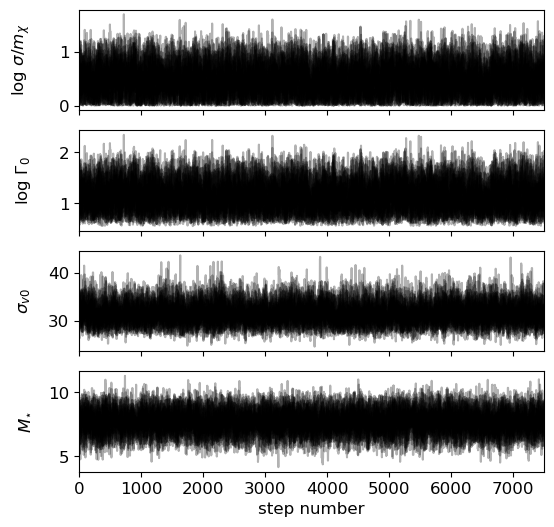

In [10]:
#Membuat plot masing-masing parameter (MCMC chains) untuk mengecek konvergensi
fig, axes = plt.subplots(ndim, figsize=(6, 6), sharex=True)
samples = sampler.get_chain()
labels = [r"$\log\,\sigma/m_{{\chi}}$", r"$\log\,\Gamma_0$", r"$\sigma_{v0}$", r"$M_{\star}$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.tick_params(axis="x", labelsize=12) # new
    ax.tick_params(axis="y", labelsize=12) # new
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=12)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontsize=12);
plt.savefig('Trace plot {} (SIDM).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi=200)

In [11]:
# Flat: concatenating the samples from each walker in the chain
# Discard: menghapus X sampel (flattened) pertama
# Thin: mengambil sampel kelipatan ke-X saja (untuk merampingkan sampel dan menghemat ukuran sampel)
flat_samples = sampler.get_chain(thin=5, flat=True)
np.savetxt("Flat samples {} (SIDM).txt".format(df['ID'][0]), np.c_[flat_samples[:, 0],flat_samples[:, 1],flat_samples[:, 2],flat_samples[:,3]])

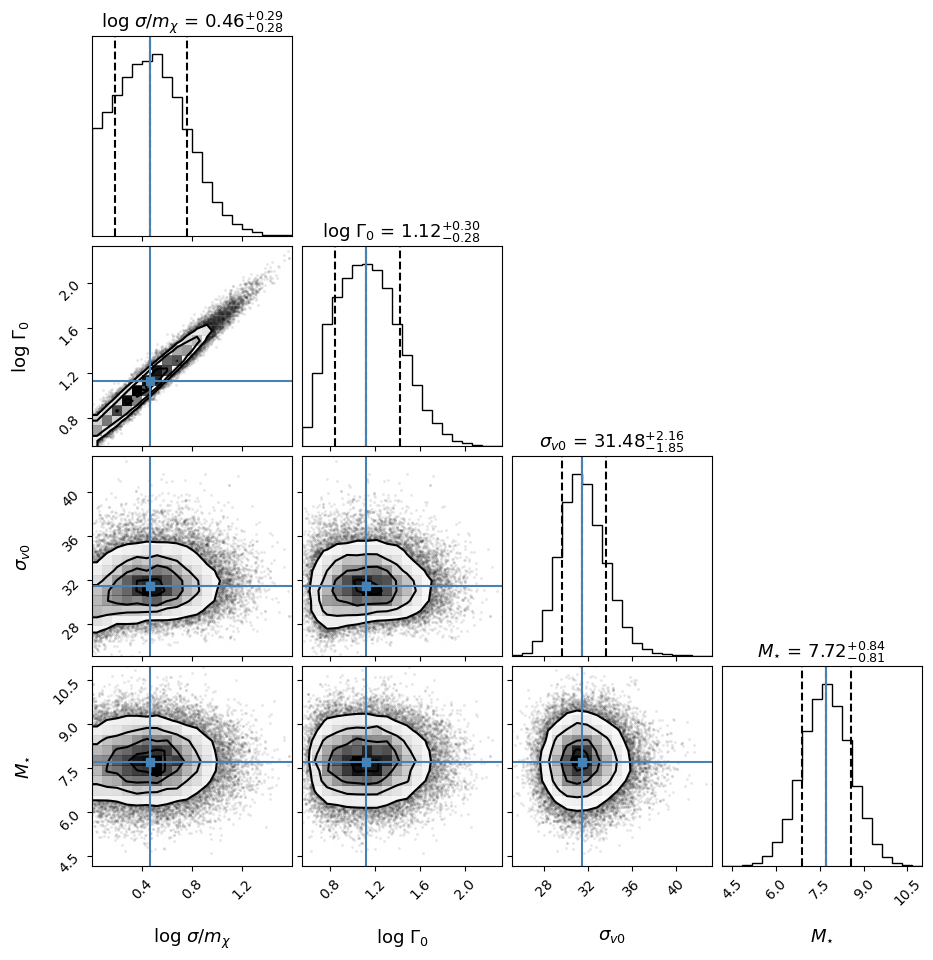

In [9]:
#Membuat corner plot
#Menyimpan nilai best-fit parameter hasil MCMC
flat_samples = np.loadtxt("Flat samples {} (SIDM).txt".format(df['ID'][0]))
labels = [r"$\log\,\sigma/m_{{\chi}}$", r"$\log\,\Gamma_0$", r"$\sigma_{v0}$", r"$M_{\star}$"]
sigma_m = np.median(flat_samples[:, 0])
logGam0 = np.median(flat_samples[:, 1])
sigmav0 = np.median(flat_samples[:, 2])
M_disk = np.median(flat_samples[:, 3])

fig = corner.corner(flat_samples,show_titles=True,title_kwargs={"fontsize":13},labels=labels,label_kwargs={"fontsize":13},plot_datapoints=True,truths=[sigma_m, logGam0,sigmav0, M_disk],quantiles=[0.16, 0.5, 0.84],dpi=200)
plt.savefig('Corner plot {} (SIDM).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi=200)

In [10]:
#Menghitung kecepatan komponen halo DM dan kecepatan total menggunakan nilai best-fit
vDM = VSIDM(sigma_m, logGam0, sigmav0, lambda r: Vdisk(rad, r_star, M_disk), lambda r: Vgas(rad, r_gas, M_gas), rad, 0)
vdisk = Vdisk(rad, M_disk, r_star)
vgas = Vgas(rad, M_gas, r_gas)
vtot = Vtot(vDM, vdisk, vgas, M_disk, M_gas)

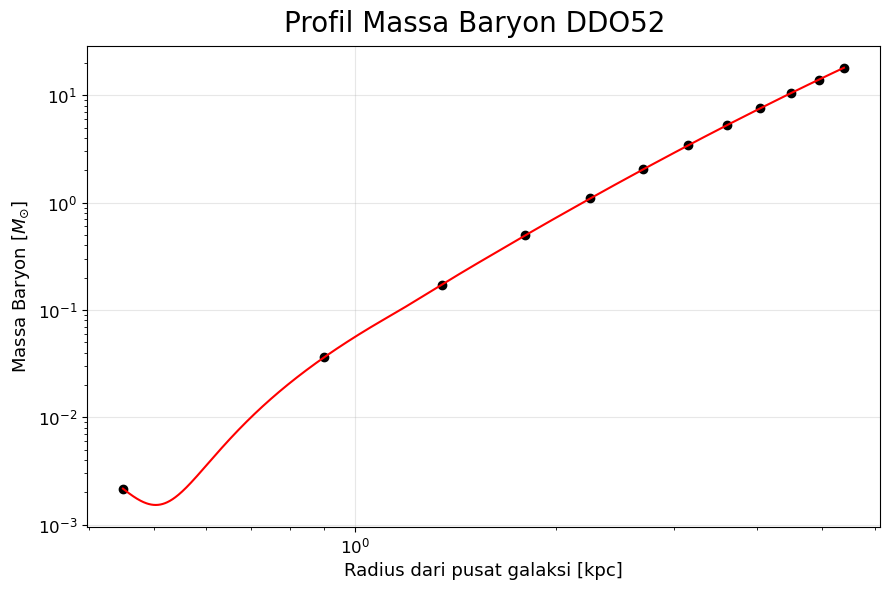

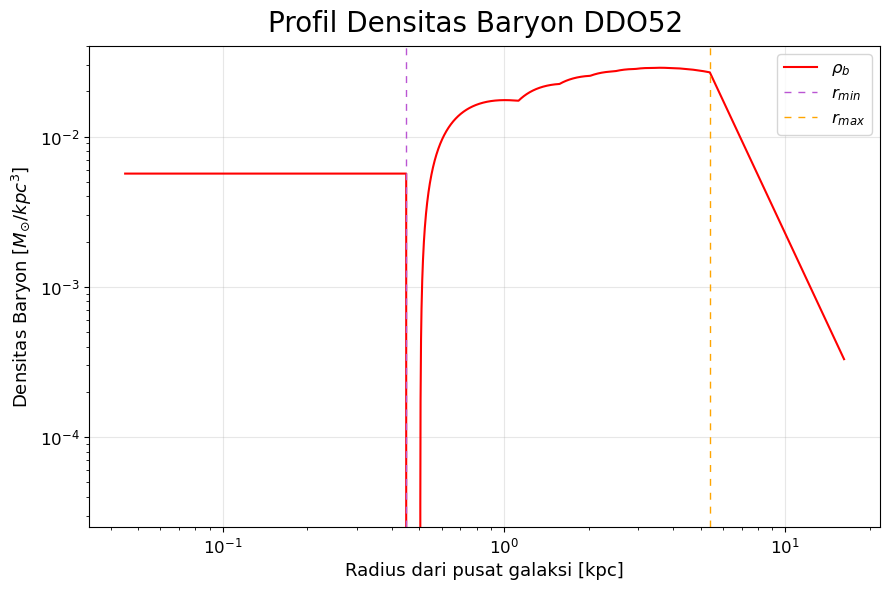

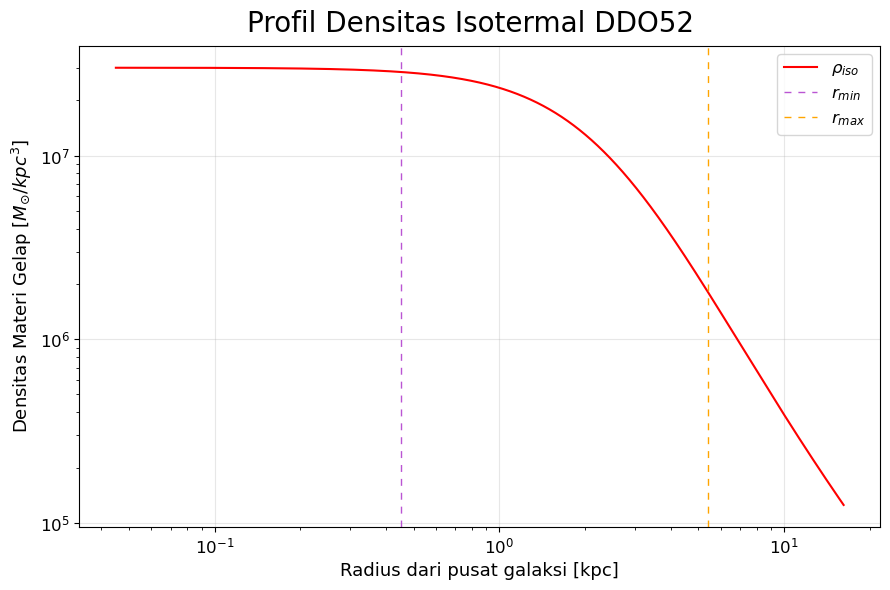

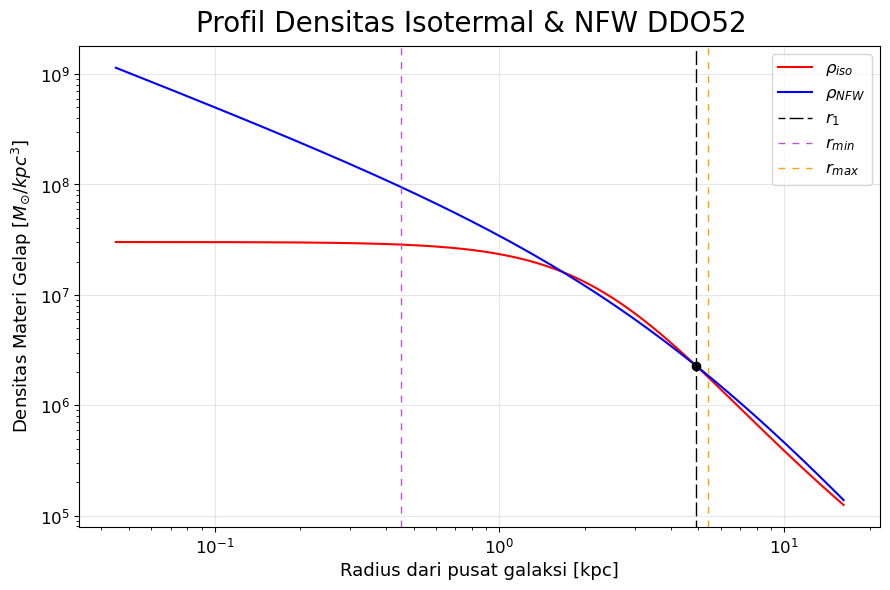

The radius where rho is 0.5 * rho_0 is: 1.777


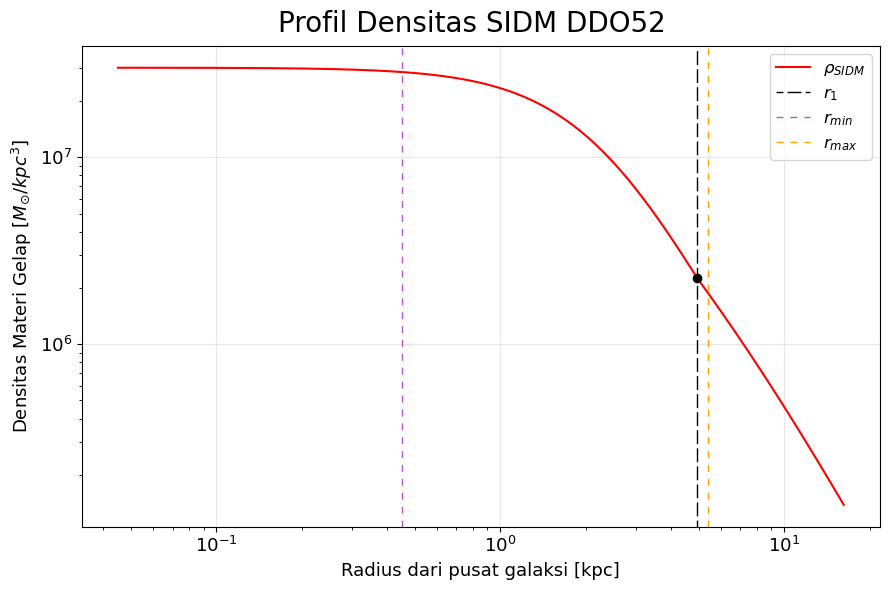

In [11]:
# Menampilkan seluruh plot yang dibuat dalam proses menurunkan kurva rotasi SIDM dan menyimpan nilai rho_0, rho_t, r1, rs, dan rho_s
rho_0, rho_t, r1, rs, rho_s = VSIDM(sigma_m, logGam0, sigmav0, lambda r: Vdisk(rad, r_star, M_disk), lambda r: Vgas(rad, r_gas, M_gas), rad, 1)

In [12]:
# Menuliskan nilai best-fit parameter hasil MCMC dan reduced chi squared
labels2 = [r'\log\,\sigma/m_{\chi}', r'\log\,\Gamma_0', r'\sigma_{v0}', r'M_{\star}']
ndim = 4
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels2[i])
    display(Math(txt))

# Menuliskan rho_0, rho_t, r1, rs, dan rho_s
trho_0 = "\mathrm \\rho_0 = {0:.3f} \, M_{{\odot}}/\\textrm{{kpc}}^3".format(rho_0)
trho_t = "\mathrm \\rho(r_1) = {0:.3f} \, M_{{\odot}}/\\textrm{{kpc}}^3".format(rho_t)
tr1 = "\mathrm r_{{1}} = {0:.3f} \, \\textrm{{kpc}}".format(r1)
trs = "\mathrm r_{{s}} = {0:.3f} \, \\textrm{{kpc}}".format(rs)
trho_s = "\mathrm \\rho_{{s}} = {0:.3f} \, M_{{\odot}}/\\textrm{{kpc}}^3".format(rho_s)
display(Math(trho_0))
display(Math(trho_t))
display(Math(tr1))
display(Math(trs))
display(Math(trho_s))

chisq = 0.
for i in range(len(rad)):
    chisq = chisq + (((Vobs[i] - vtot[i])**2)/(Vobs_err[i])**2)

red_chisq = chisq/(len(rad) - ndim) # reduced chi squared
txt2 = "\mathrm\chi_{{\\nu}}^2 = {0:.3f}".format(red_chisq)
display(Math(txt2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [16]:
print("Mean acceptance fraction (SIDM): {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print("Mean autocorrelation time (SIDM): {0:.3f}".format(np.mean(sampler.get_autocorr_time())))

Mean acceptance fraction (SIDM): 0.580
Mean autocorrelation time (SIDM): 50.705


In [17]:
np.savetxt('Mass model {} (SIDM).txt'.format(df['ID'][0]), np.c_[rad,Vobs,Vobs_err,vgas,vdisk,vDM,vtot], fmt='% 1.3f', header='R     Vobs    eVobs  Vgas    Vdisk   VDM     Vtot')

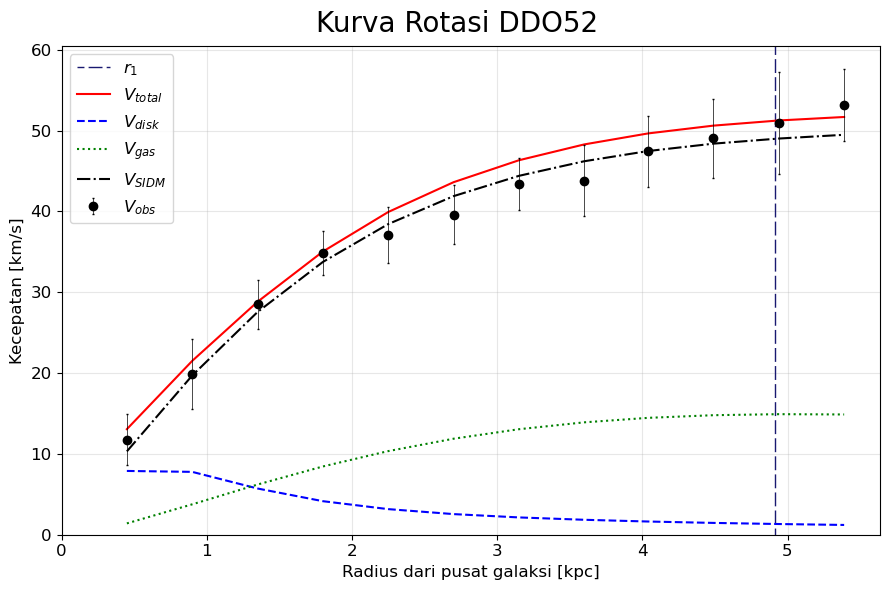

In [13]:
#Membuat plot kurva rotasi (dengan r1)
plt.figure(figsize=(9,6))
plt.axvline(x = r1, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_1$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, vdisk, label='$V_{disk}$', c="blue", linewidth=1.5, linestyle='dashed') # Komponen disk
plt.plot(rad, vgas, label='$V_{gas}$', c="green", linewidth=1.5, linestyle='dotted')# Komponen gas
plt.plot(rad, vDM, label = '$V_{SIDM}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title(r'Kurva Rotasi {}   '.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xticks(fontsize=12); plt.yticks(fontsize=12) # new
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} (SIDM).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 150)
plt.show()

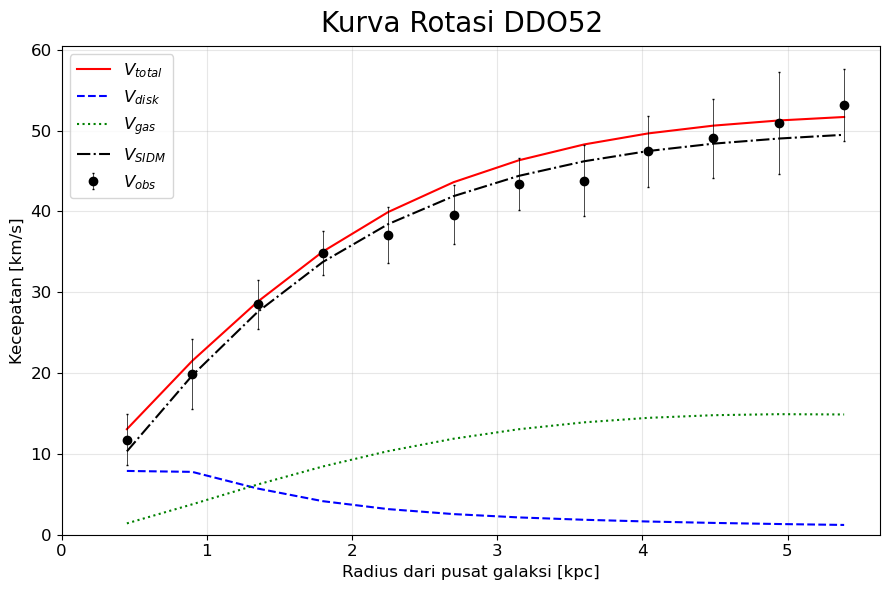

In [14]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, vdisk, label='$V_{disk}$', c="blue", linewidth=1.5, linestyle='dashed') # Komponen disk
plt.plot(rad, vgas, label='$V_{gas}$', c="green", linewidth=1.5, linestyle='dotted')# Komponen gas
plt.plot(rad, vDM, label = '$V_{SIDM}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title(r'Kurva Rotasi {}  '.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xticks(fontsize=12); plt.yticks(fontsize=12) # new
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi 2 {} (SIDM).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
plt.show()

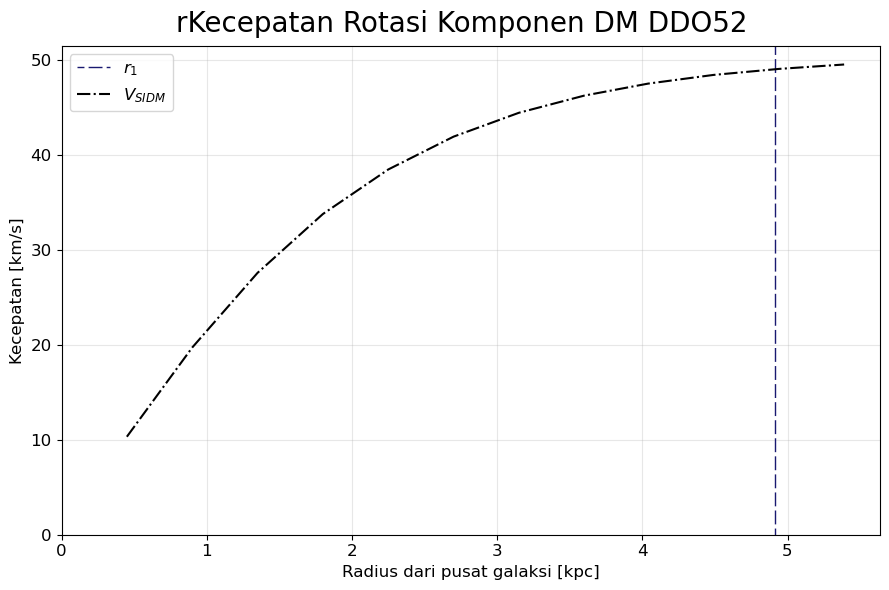

In [15]:
#Membuat plot kurva rotasi komponen DM
plt.figure(figsize=(9,6))
plt.axvline(x = r1, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_1$')
plt.plot(rad, vDM, label = '$V_{SIDM}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title('rKecepatan Rotasi Komponen DM {}  '.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xticks(fontsize=12); plt.yticks(fontsize=12) # new
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kecepatan Rotasi Komponen DM {} (SIDM).jpg'.format(df['ID'][0]), format = 'jpg', dpi = 200)
plt.show()

## 1sigma posterior spread

In [16]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        vDM = VSIDM(sigma_m, logGam0, sigmav0, lambda r: Vdisk(rad, r_star, M_disk), lambda r: Vgas(rad, r_gas, M_gas), rad, 0)
        vtot = Vtot(vDM, vdisk, vgas, M_disk, M_gas)
        models.append(vtot)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(500,flat_samples)

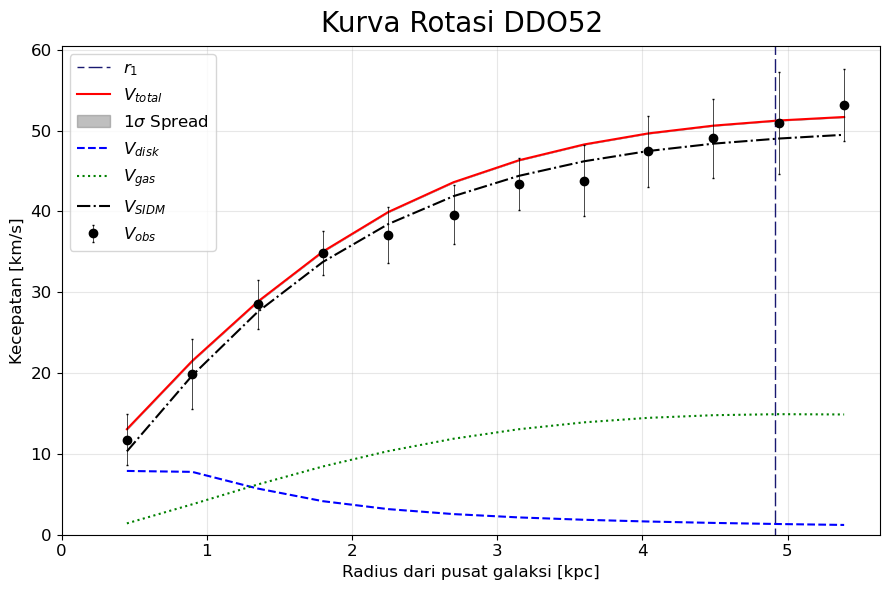

In [17]:
#Membuat plot kurva rotasi dengan 1sigma posterior spread
plt.figure(figsize=(9,6))
plt.axvline(x = r1, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_1$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.fill_between(rad,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Spread')
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, vdisk, label='$V_{disk}$', c="blue", linewidth=1.5, linestyle='dashed') # Komponen disk
plt.plot(rad, vgas, label='$V_{gas}$', c="green", linewidth=1.5, linestyle='dotted')# Komponen gas
plt.plot(rad, vDM, label = '$V_{SIDM}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title(r'Kurva Rotasi {}  '.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,) # new
plt.xticks(fontsize=12); plt.yticks(fontsize=12) # new
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} 1sigma (SIDM).jpg'.format(df['ID'][0]), format = 'jpg', dpi = 150)
plt.show()

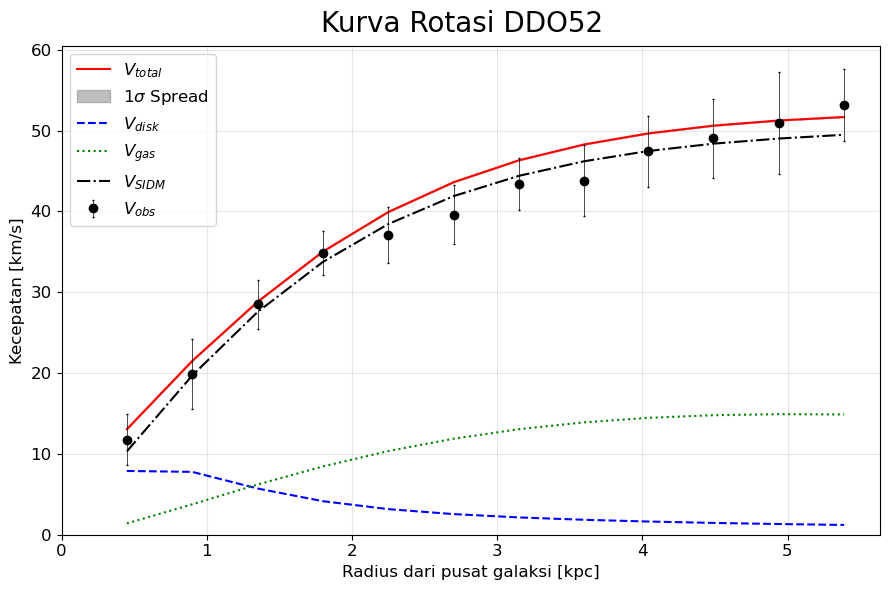

In [18]:
#Membuat plot kurva rotasi dengan 1sigma posterior spread
plt.figure(figsize=(9,6))
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.fill_between(rad,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Spread')
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, vdisk, label='$V_{disk}$', c="blue", linewidth=1.5, linestyle='dashed') # Komponen disk
plt.plot(rad, vgas, label='$V_{gas}$', c="green", linewidth=1.5, linestyle='dotted')# Komponen gas
plt.plot(rad, vDM, label = '$V_{SIDM}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title(r'Kurva Rotasi {}  '.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,) # new
plt.xticks(fontsize=12); plt.yticks(fontsize=12) # new
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi {} 1sigma 2 (SIDM).jpg'.format(df['ID'][0]), format = 'jpg', dpi = 150)
plt.show()

### Maximum A Posteriori

In [19]:
def VSIDM2(sigma_m, logGam0, sigmav0, Vdisk_func, Vgas_func, rad, returnfig):
    vdisk = Vdisk_func(rad)
    vgas = Vgas_func(rad)
    # Profil massa Baryon
    Mb = []
    for i in range(len(rad)):
        mb = max(0, ((vdisk[i]**2) + vgas[i]*np.abs(vgas[i]))*rad[i]/G)
        #mb = ((Vdisk_func(rad)[i]**2) + Vgas_func(rad)[i]*np.abs(Vgas_func(rad)[i]))*rad[i]/G  # Use Vdisk_func and Vgas_func
        Mb.append(mb)

    Mb_f = interp1d(rad, Mb, kind='quadratic', bounds_error=False, fill_value='extrapolate')
    dMb = nd.Derivative(Mb_f, n=1)
    dMb_dr = dMb(r)

    # Profil densitas inti isotermal
    dMb_drmax = dMb_dr[np.where(r == rmax)]
    rho_0 = (10**logGam0)*(3.086e+21**2)*3.086e+16*np.sqrt(math.pi)/(10**sigma_m*1.989e+33*4*sigmav0*3.1536e+16*10) # Msun/kpc^3
    p0 = [np.log(rho_0), 0.0]
    
    sol = odeint(lnrhoiso, p0, r, args=(sigmav0, Mb, dMb, dMb_drmax))
    rho_iso = np.exp(sol[:,0])

    # Densitas dan radius transisi
    rho_t = rho_0/(t_age * 10**logGam0 / 10)
    r1 = round(np.interp(rho_t, np.flip(rho_iso), np.flip(r)), 3) # kpc

    # Menghitung rs dan rho_s
    y_iso = []
    a = 0
    
    for i in range(len(rf)):
        if rf[i] < r[0]:
            yiso = rf[i]**2 * rho_iso[0]
            y_iso.append(yiso)
        elif r[0] <= rf[i] <= r1:
            yiso = rf[i]**2 * rho_iso[a]
            a += 1
            y_iso.append(yiso)
        else: # r[i] > r1
            break

    A_iso = simps(y_iso, rf[:int(np.where(rf == r1)[0])+1], even='avg')

    rs0 = 1.0 # initial
    drs = 1.0 # initial
    rs = 1.0 # initial
    rep = 0 # initial
    while drs > 0.001:
        rep += 1
        rs = r1/(np.exp(r1/(rs0+r1) + A_iso/(r1*rho_t*((rs0+r1)**2))) - 1) # revisi persamaan kontinuitas massa
        if math.isnan(rs):
            rs = np.inf
            break
        drs = np.abs(rs - rs0)
        rs0 = rs
        if rep == 100: # batas iterasi maksimum
            rs = np.inf
            break
    if np.isfinite(rs):
        rs = round(rs, 3) # kpc
        rho_s = rho_t*r1*((1 + r1/rs)**2)/rs
    else: # rs is infinite, break
        V_SIDM = np.array([0.0 for i in range(len(rad))])
        return V_SIDM

    # Kurva rotasi SIDM
    y_iso = []
    j = r[:int(np.where(r == r1)[0])+1]
    M_NFWdel = 4*math.pi*rho_s*(rs**3)*(np.log(1 + r1/rs) - r1/(rs + r1))

    V_SIDM = []
    k = 0
    for i in range(len(r)):
        if r[i] < r1:
            if r[i] > rmax:
                break
            yiso = r[i]**2 * rho_iso[i]
            y_iso.append(yiso)

            if r[i] == rad[k]:
                k += 1
                M_iso = 4*math.pi*simps(y_iso, r[:int(np.where(r == r[i])[0])+1], even='avg')
                vsidm = np.sqrt(G*M_iso/r[i])
                V_SIDM.append(vsidm)
                #print(f"r: {r[i]}, rho_iso: {rho_iso[i]}, M_iso: {M_iso}, vsidm: {vsidm}")
        elif r[i] == r1: # revised, supaya M_iso yang digunakan di else adalah M_iso sampai r1
            if r[i] > rmax:
                break
            yiso = r[i]**2 * rho_iso[i]
            y_iso.append(yiso)
            M_iso = 4*math.pi*simps(y_iso, j, even='avg')
            
            if r[i] == rad[k]:
                k += 1
                vsidm = np.sqrt(G*M_iso/r[i])
                V_SIDM.append(vsidm)
        else: # r[i] > r1
            if r[i] > rmax:
                break

            if r[i] == rad[k]:
                k += 1
                M_NFW = 4*math.pi*rho_s*(rs**3)*(np.log(1 + r[i]/rs) - r[i]/(rs + r[i])) - M_NFWdel
                vsidm = np.sqrt(G*(M_iso + M_NFW)/r[i])
                V_SIDM.append(vsidm)
    V_SIDM = np.array(V_SIDM)
    
    if returnfig == 1:
        # Profil Massa Baryon
        plt.figure(figsize=(9,6))
        plt.plot(rad, Mb, 'ko', xnew, Mb_f(xnew), 'r-')
        plt.title(r'Profil Massa Baryon {}  '.format(df['ID'][0]), pad=10, size=20)
        #plt.xlim(0,)
        plt.yscale('log')
        plt.xscale('log', base=10)

        plt.yticks(fontsize=12); plt.xticks(fontsize=12)
        plt.xlabel('Radius dari pusat galaksi [kpc]', size=13)
        plt.ylabel(r'Massa Baryon [$M_{\odot}$]', size=13)
        plt.tight_layout()
        plt.grid(alpha = 0.3)
        plt.savefig('Profil Massa Baryon SIDM {}.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas Baryon
        rho_b = []
        for i in range(len(r)):
            if r[i] < rad[0]:
                rhob = Mb[0]/(4*math.pi*(rad[0]**3)/3)
                rho_b.append(rhob)
            elif r[i] >= rad[0] and r[i] <= rmax:
                rhob = dMb_dr[i]/(4*math.pi*(r[i]**2))
                rho_b.append(rhob)
            else:
                rhob = float(dMb_drmax)/(4*math.pi*(rmax**2)) * (rmax/r[i])**4
                rho_b.append(rhob)
        rho_b = np.array(rho_b)
        
        plt.figure(figsize=(9,6))
        plt.plot(r, rho_b, label = r'$\rho_b$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        plt.title(r'Profil Densitas Baryon {}  '.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius dari pusat galaksi [kpc]', size=13)
        plt.ylabel(r'Densitas Baryon [$M_{\odot}/{kpc^3}$]', size=13)
        plt.yscale('log', base=10); plt.xscale('log', base=10)
        plt.xticks(fontsize=12); plt.yticks(fontsize=12)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(alpha = 0.3)
        plt.savefig('Profil Densitas Baryon SIDM {}.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas Isotermal
        plt.figure(figsize=(9,6))
        plt.plot(r, rho_iso, label = r'$\rho_{iso}$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        plt.title(r'Profil Densitas Isotermal {}  '.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius dari pusat galaksi [kpc]', size=13)
        plt.ylabel(r'Densitas Materi Gelap [$M_{\odot}/{kpc^3}$]', size=13)
        plt.yscale('log', base=10); plt.xscale('log', base=10)
        plt.xticks(fontsize=12); plt.yticks(fontsize=12)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(alpha = 0.3)
        plt.savefig('Profil Densitas SIDM Iso {}.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas Iso & NFW
        rho_NFW = []
        for i in range(len(r)):
            rhonfw = rho_s/(r[i]/rs * (1 + r[i]/rs)**2)
            rho_NFW.append(rhonfw)
        
        plt.figure(figsize=(9,6))
        plt.plot(r, rho_iso, label = r'$\rho_{iso}$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.plot(r, rho_NFW, label = r'$\rho_{NFW}$', c = "blue", linewidth = 1.5, linestyle = 'solid')
        plt.plot(r1, rho_t, 'ko')
        plt.axvline(r1, c = "black", linewidth = 1.0, linestyle = (5, (10, 3)), label=r'$r_1$')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        plt.title('Profil Densitas Isotermal & NFW {}  '.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius dari pusat galaksi [kpc]', size=13)
        plt.ylabel(r'Densitas Materi Gelap [$M_{\odot}/{kpc^3}$]', size=13)
        plt.yscale('log', base=10); plt.xscale('log', base=10)
        plt.xticks(fontsize=12); plt.yticks(fontsize=12)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(alpha = 0.3)
        plt.savefig('Profil Densitas SIDM Iso NFW {}.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        
        # Profil Densitas SIDM
        rho_SIDM = []
        r_half = None
        for i in range(len(r)):
            if r[i] <= r1:
                rho_SIDM.append(rho_iso[i])
            else: # r[i] > r1
                rho_SIDM.append(rho_NFW[i])
        # Find r where rho is 0.5 * rho_0
        for i in range(len(rho_SIDM)):
            if rho_SIDM[i] <= 0.5 * rho_0:
                r_half = r[i]
                break
        if r_half is not None:
            print(f"The radius where rho is 0.5 * rho_0 is: {r_half}")
        else:
            print("No radius found where rho is 0.5 * rho_0.")

        plt.figure(figsize=(9,6))
        plt.plot(r, rho_SIDM, label = r'$\rho_{SIDM}$', c = "red", linewidth = 1.5, linestyle = 'solid')
        plt.plot(r1, rho_t, 'ko')
        plt.axvline(r1, c = "black", linewidth = 1.0, linestyle = (5, (10, 3)), label=r'$r_1$')
        plt.axvline(rmin, c = "mediumorchid", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{min}$')
        plt.axvline(rmax, c = "orange", linewidth = 1.0, linestyle = (0, (5, 5)), label=r'$r_{max}$')
        plt.title('Profil Densitas SIDM {}  '.format(df['ID'][0]), pad=10, size=20)
        plt.xlabel('Radius dari pusat galaksi [kpc]', size=13)
        plt.ylabel(r'Densitas Materi Gelap [$M_{\odot}/{kpc^3}$]', size=13)
        plt.yscale('log', base=10); plt.xscale('log', base=10)
        plt.xticks(fontsize=13); plt.yticks(fontsize=13)
        plt.legend(fontsize = 12)
        plt.tight_layout()
        plt.grid(alpha = 0.3)
        plt.savefig('Profil Densitas DM SIDM {}.jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
        plt.show()
        np.savetxt('profil densitas {} (SIDM).txt'.format(df['ID'][0]), np.c_[r, rho_SIDM], fmt='% 1.3f', header='R     rho_SIDM')

        return rho_0, rho_t, r1, rs, rho_s
    else: # returnfig == 0
        return V_SIDM
    
#Fungsi model kecepatan rotasi total
def Vtot(vDM, Vdisk, Vgas, M_disk, M_gas):
    return np.sqrt(vDM**2 + Vdisk**2 + Vgas**2)

In [25]:
lnprob_samples = sampler.get_log_prob(thin=5, flat=True)
np.savetxt("Lnprob samples {} (SIDM).txt".format(df['ID'][0]), np.c_[lnprob_samples[:]])

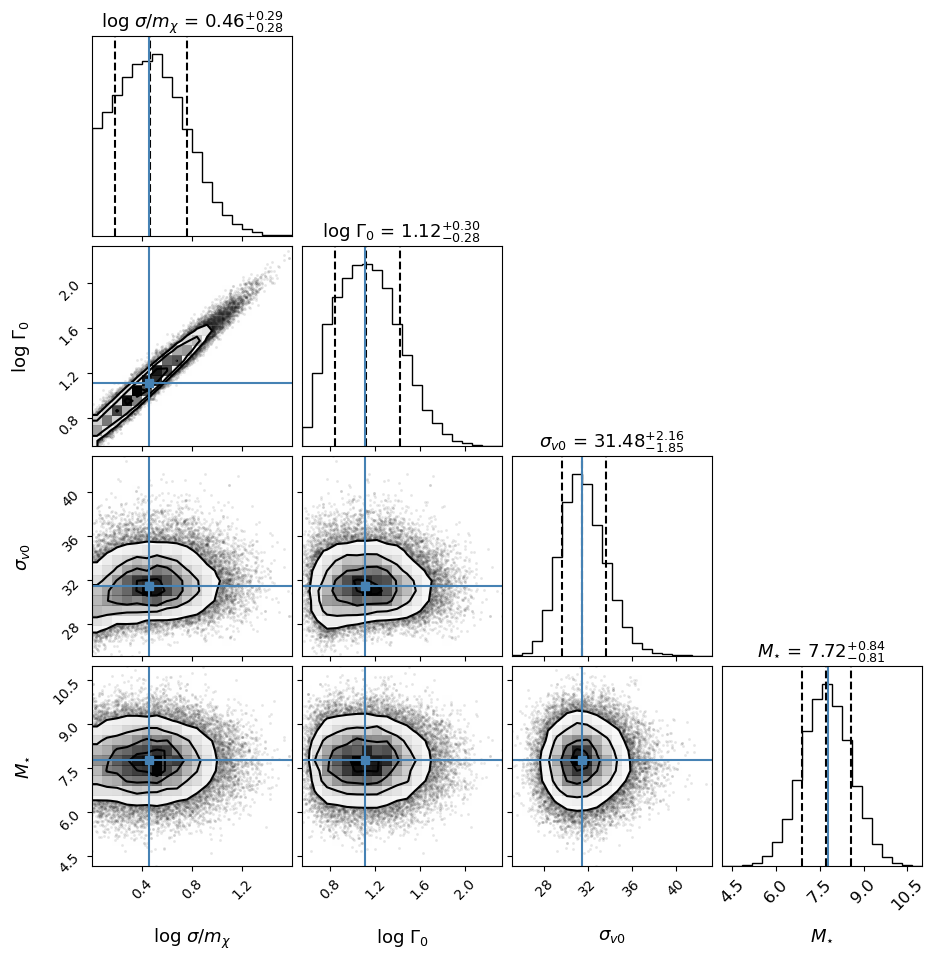

In [20]:
lnprob_samples = np.loadtxt("Lnprob samples {} (SIDM).txt".format(df['ID'][0]))
theta_max = flat_samples[np.argmax(lnprob_samples)]

#Menyimpan nilai best-fit parameter hasil MCMC
sigma_m = theta_max[0]
logGam0 = theta_max[1]
sigmav0 = theta_max[2]
M_disk = theta_max[3]

fig = corner.corner(flat_samples,show_titles=True,title_kwargs={"fontsize":13},labels=labels,label_kwargs={"fontsize":13},plot_datapoints=True,truths=[sigma_m, logGam0,sigmav0, M_disk], quantiles=[0.16, 0.5, 0.84],dpi=200)
plt.xticks(fontsize=12); plt.yticks(fontsize=12) # new
plt.savefig('Corner plot MAP {} (SIDM).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi=300)

In [21]:
# Find the index of the maximum log-probability
max_lnprob_index = np.argmax(lnprob_samples)

# Calculate the maximum likelihood (exponent of the maximum log-probability)
max_likelihood = np.exp(lnprob_samples[max_lnprob_index])

# Number of parameters in the model
k = len(theta_max)

# Number of data points (assuming `n` is provided, e.g., `n` is the length of the data)
n = len(df)

# Calculate BIC
bic = k * np.log(n) - 2 * lnprob_samples[max_lnprob_index]

print("ml:", max_likelihood)
print("BIC:", bic)

np.savetxt('BIC {} (SIDM).txt'.format(df['ID'][0]), np.c_[bic], fmt='% 1.3f', header='BIC')

ml: 1.0484197069244495e-15
BIC: 78.922611410107


In [22]:
#Menghitung kecepatan komponen halo DM dan kecepatan total menggunakan nilai best-fit
vDM = VSIDM2(sigma_m, logGam0, sigmav0, lambda r: Vdisk(rad, r_star, M_disk), lambda r: Vgas(rad, r_gas, M_gas), rad, 0)
vdisk = Vdisk(rad, M_disk, r_star)
vgas = Vgas(rad, M_gas, r_gas)
vtot = Vtot(vDM, vdisk, vgas, M_disk, M_gas)

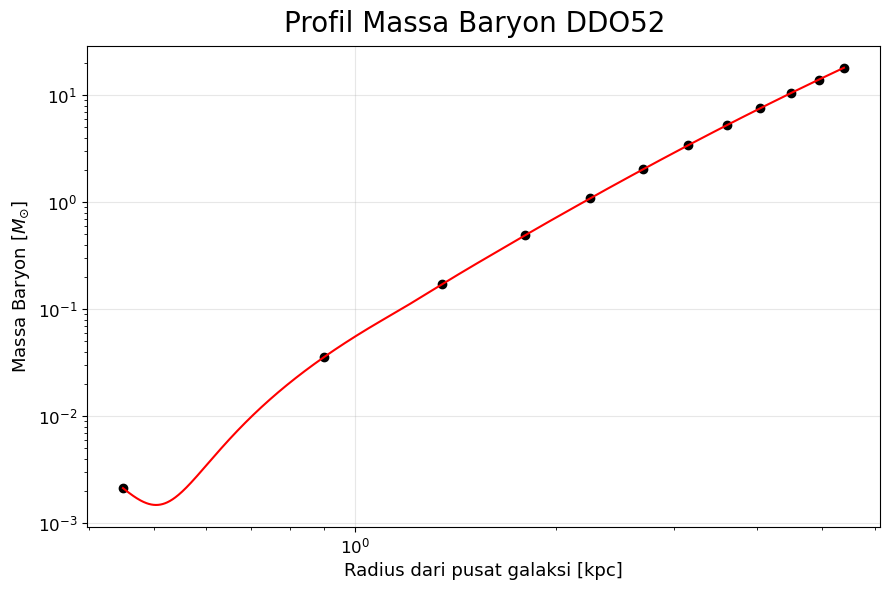

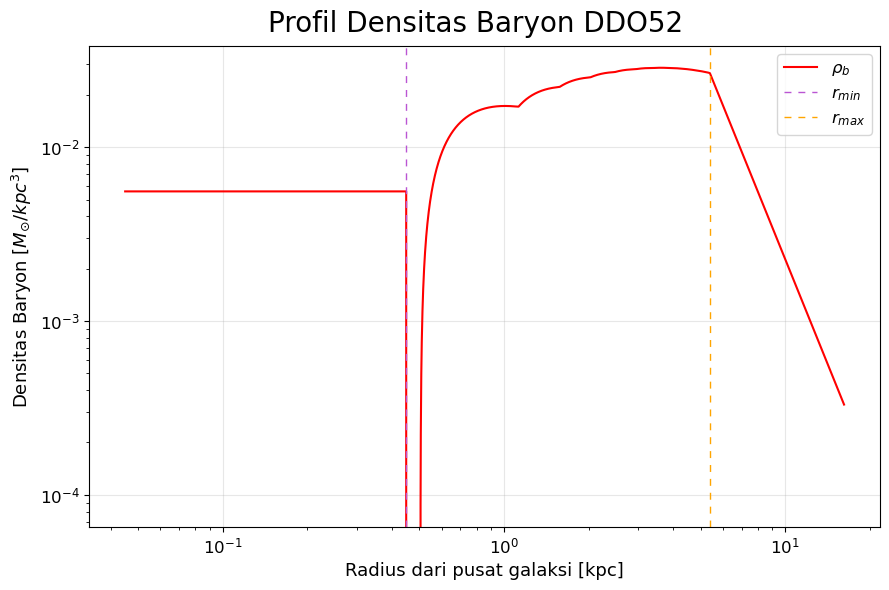

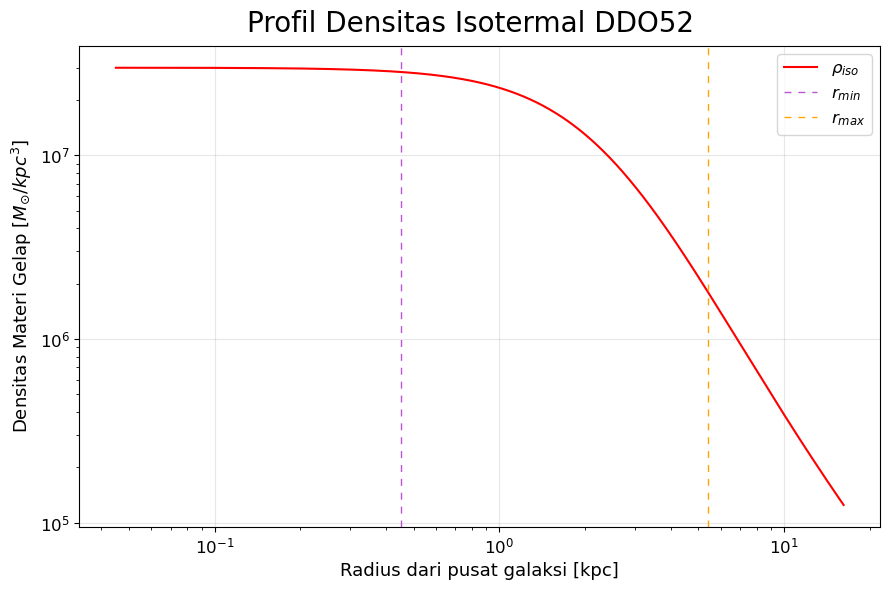

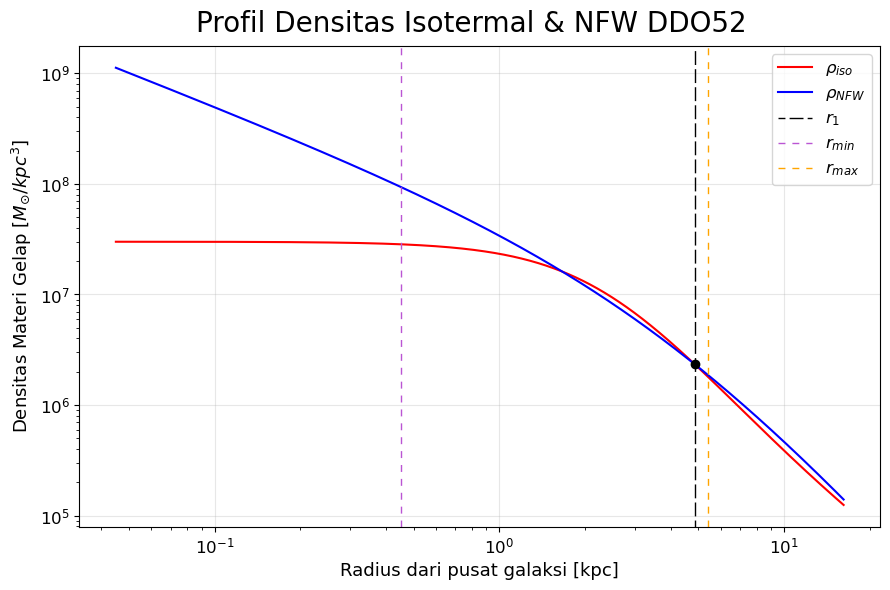

The radius where rho is 0.5 * rho_0 is: 1.778


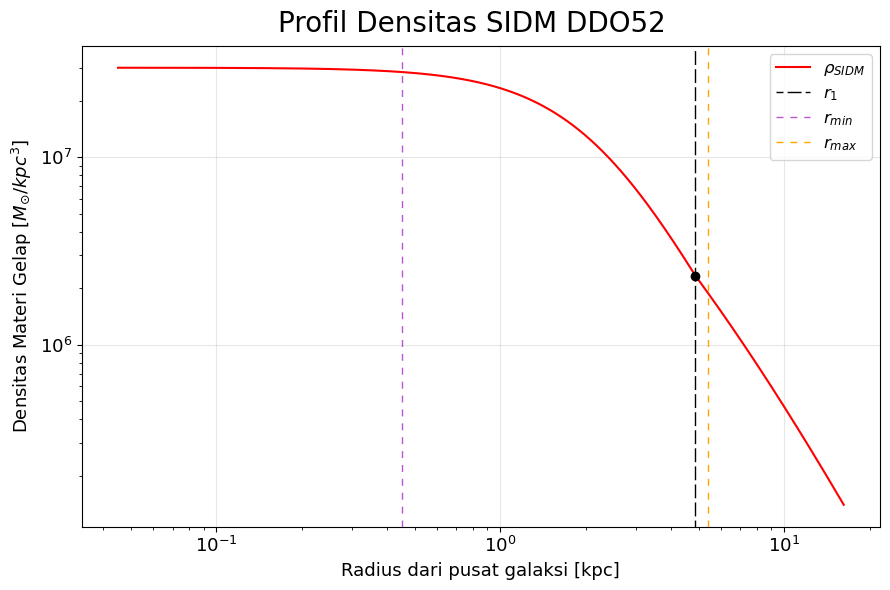

In [23]:
# Menampilkan seluruh plot yang dibuat dalam proses menurunkan kurva rotasi SIDM dan menyimpan nilai rho_0, rho_t, r1, rs, dan rho_s
rho_0, rho_t, r1, rs, rho_s = VSIDM2(sigma_m, logGam0, sigmav0, lambda r: Vdisk(rad, r_star, M_disk), lambda r: Vgas(rad, r_gas, M_gas), rad, 1)

In [24]:
#Menuliskan nilai best-fit parameter hasil MCMC dan reduced chi squared
labels2 = [r'\log\,\sigma/m_{\chi}', r'\log\,\Gamma_0', r'\sigma_{v0}', r'M_{\star}']
ndim = 4
for i in range(ndim):
    std = np.std(flat_samples[:, i])
    txt = "\mathrm{{{2}}} = {0:.3f} \pm {1:.3f}"
    txt = txt.format(theta_max[i], std, labels2[i])
    display(Math(txt))

# Menuliskan rho_0, rho_t, r1, rs, dan rho_s
trho_0 = "\mathrm \\rho_0 = {0:.3f} \, M_{{\odot}}/\\textrm{{kpc}}^3".format(rho_0)
trho_t = "\mathrm \\rho(r_1) = {0:.3f} \, M_{{\odot}}/\\textrm{{kpc}}^3".format(rho_t)
tr1 = "\mathrm r_{{1}} = {0:.3f} \, \\textrm{{kpc}}".format(r1)
trs = "\mathrm r_{{s}} = {0:.3f} \, \\textrm{{kpc}}".format(rs)
trho_s = "\mathrm \\rho_{{s}} = {0:.3f} \, M_{{\odot}}/\\textrm{{kpc}}^3".format(rho_s)
display(Math(trho_0))
display(Math(trho_t))
display(Math(tr1))
display(Math(trs))
display(Math(trho_s))
    
chisq = 0.
for i in range(len(rad)):
    chisq = chisq + ((Vobs[i] - vtot[i])**2) / (Vobs_err[i])**2

red_chisq = chisq/(len(rad) - ndim) #reduced chi squared
txt2 = "\mathrm\chi_{{\\nu}}^2 = {0:.3f}".format(red_chisq)
display(Math(txt2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

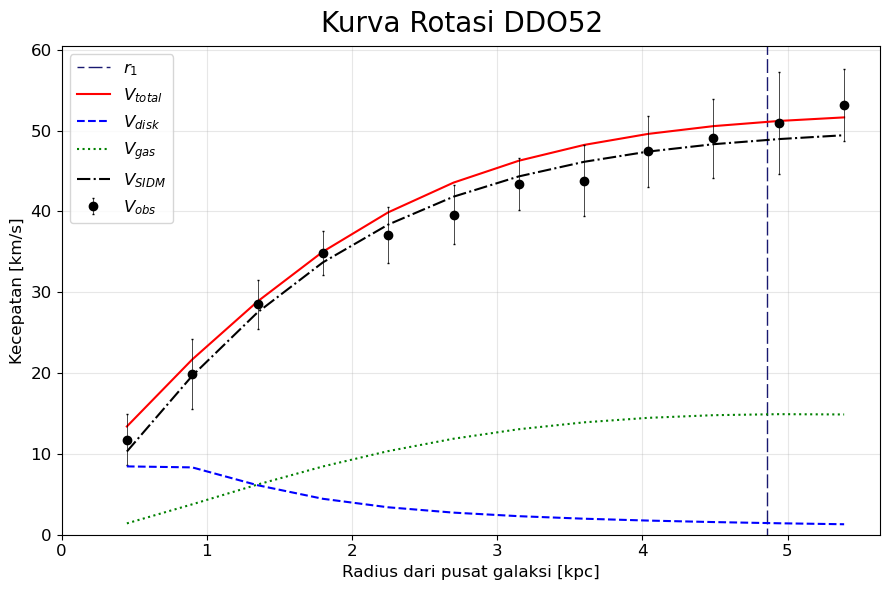

In [25]:
#Membuat plot kurva rotasi (dengan r1)
plt.figure(figsize=(9,6))
plt.axvline(x = r1, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_1$')
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, vdisk, label='$V_{disk}$', c="blue", linewidth=1.5, linestyle='dashed') # Komponen disk
plt.plot(rad, vgas, label='$V_{gas}$', c="green", linewidth=1.5, linestyle='dotted')
plt.plot(rad, vDM, label = '$V_{SIDM}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title(r'Kurva Rotasi {}  '.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xticks(fontsize=12); plt.yticks(fontsize=12) # new
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi MAP {} (SIDM).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
plt.show()

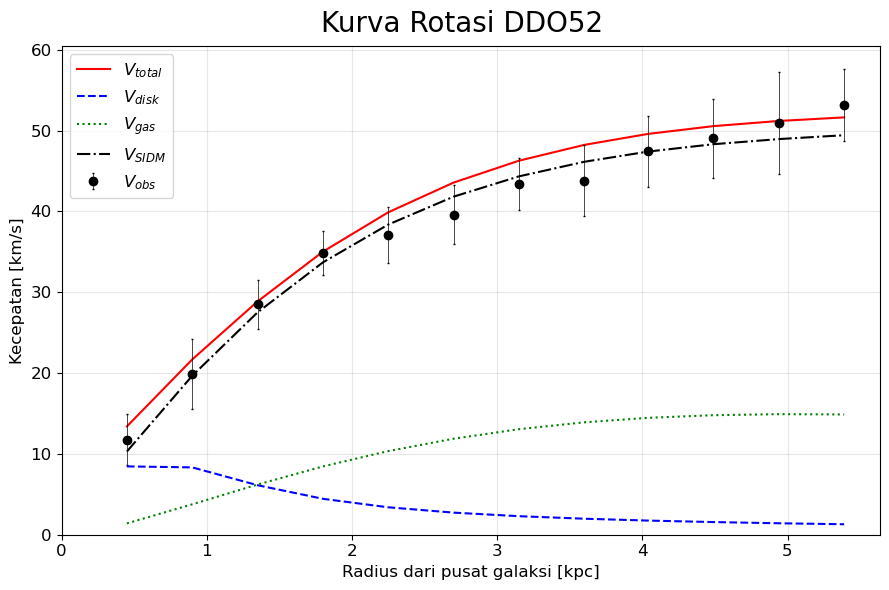

In [26]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
plt.plot(rad, vtot, label = '$V_{total}$', c = "red", linewidth = 1.5, linestyle = 'solid') # Komponen total
plt.errorbar(rad, Vobs, Vobs_err, label = '$V_{obs}$', elinewidth = 0.5, fmt = 'ko', capsize = 1) # Komponen teramati
plt.plot(rad, vdisk, label='$V_{disk}$', c="blue", linewidth=1.5, linestyle='dashed') # Komponen disk
plt.plot(rad, vgas, label='$V_{gas}$', c="green", linewidth=1.5, linestyle='dotted')# Komponen gas
plt.plot(rad, vDM, label = '$V_{SIDM}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title(r'Kurva Rotasi {}  '.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xticks(fontsize=12); plt.yticks(fontsize=12) # new
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kurva Rotasi MAP 2 {} (SIDM).jpg'.format(df['ID'][0]), bbox_inches = 'tight', dpi = 200)
plt.show()

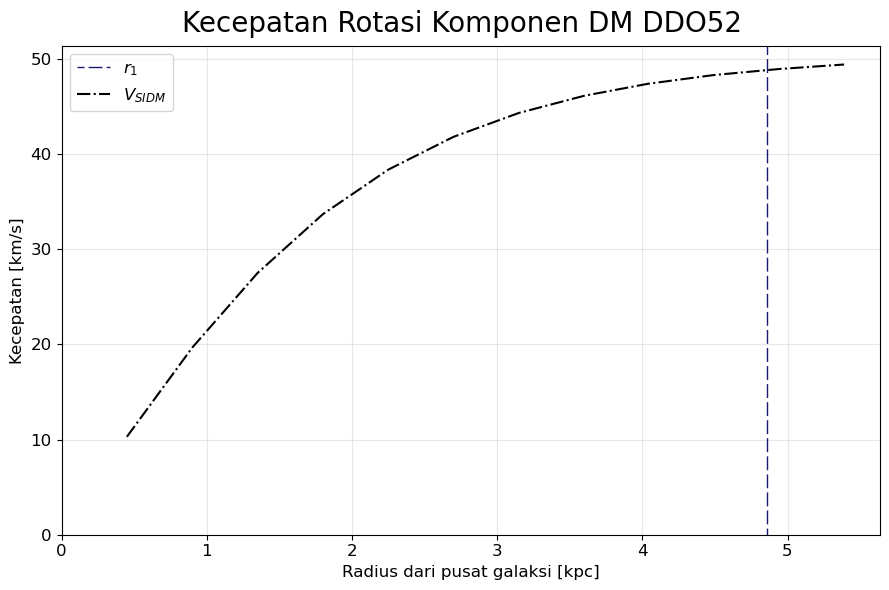

In [27]:
#Membuat plot kurva rotasi
plt.figure(figsize=(9,6))
plt.axvline(x = r1, c = 'midnightblue', linewidth = 1.0, linestyle = (5, (10, 3)), label = '$r_1$')
plt.plot(rad, vDM, label = '$V_{SIDM}$', c = "black", linewidth = 1.5, linestyle = 'dashdot') # Komponen DM
plt.title(r'Kecepatan Rotasi Komponen DM {}  '.format(df['ID'][0]), pad=10, size=20)
plt.ylim(0,); plt.xlim(0,)
plt.xticks(fontsize=12); plt.yticks(fontsize=12) # new
plt.xlabel('Radius dari pusat galaksi [kpc]', size=12)
plt.ylabel('Kecepatan [km/s]', size=12)
plt.legend(fontsize = 12)
plt.tight_layout()
plt.grid(alpha = 0.3)
plt.savefig('Kecepatan Rotasi Komponen DM MAP {} (SIDM).jpg'.format(df['ID'][0]), format = 'jpg', dpi = 200)
plt.show()

## Fraksi Dark Matter

In [28]:
# Interpolasi Kubik Profil Kecepatan
c1 = CubicSpline(rad, vtot)
c2= CubicSpline(rad, vdisk)
c3 = CubicSpline(rad, vgas)
c4 = CubicSpline(rad, vDM)

# Memperoleh nilai kecepatan di radius efektif
total = c1(r_eff)
bintang = c2(r_eff)
gas = c3(r_eff)
dm = c4(r_eff)

# Print
print(f"At x = {r_eff}, total = {total}")
print(f"At x = {r_eff}, bintang = {bintang}")
print(f"At x = {r_eff}, gas = {gas}")
print(f"At x = {r_eff}, dm = {dm}")

At x = 1.02, total = 23.695292560468072
At x = 1.02, bintang = 7.812419803655514
At x = 1.02, gas = 4.41950345248778
At x = 1.02, dm = 21.911155268662988


In [29]:
#Massa Baryon
G = 4.3e-6
Mstar = (bintang**2 * r_eff)/G
Mgas = (gas**2 * r_eff)/G
M_bar = Mstar + 1.33*(Mgas)
M_bar

20639931.87400546

In [30]:
#Massa DM
M_dm = (dm**2 * r_eff)/G
M_dm

113883883.65386207

In [31]:
#Fraksi DM
frac = M_dm/(M_bar+M_dm)
frac

0.846570424775606

In [32]:
# Use the spline interpolator to get the interpolated y-value
r_opt = (3.2/1.69)*r_eff
total1 = c1(r_opt)
bintang1 = c2(r_opt)
gas1 = c3(r_opt)
dm1 = c4(r_opt)

# Print or use the result as needed
print(f"At x = {r_opt}, total = {total1}")
print(f"At x = {r_opt}, bintang = {bintang1}")
print(f"At x = {r_opt}, gas = {gas1}")
print(f"At x = {r_opt}, dm = {dm1}")

At x = 1.9313609467455624, total = 36.57521683553041
At x = 1.9313609467455624, bintang = 4.087650034261152
At x = 1.9313609467455624, gas = 9.037250017706095
At x = 1.9313609467455624, dm = 35.20191634806232


In [33]:
Mstar1 = (bintang1**2 * r_opt)/G
Mgas1 = (gas1**2 * r_opt)/G
M_bar1 = Mstar1 + 1.33*(Mgas1)
M_bar1

56293554.340480834

In [34]:
M_dm1 = (dm1**2 * r_opt)/G
M_dm1

556580008.418328

In [35]:
frac1 = M_dm1/(M_bar1+M_dm1)
frac1

0.9081481764573444

In [36]:
rhonol = np.log10(rho_0)
rhor1 = np.log10(rho_t)
np.savetxt('Parameter {} (SIDM).txt'.format(df['ID'][0]), np.c_[rs, r1, rhonol, rhor1, red_chisq, frac, frac1], fmt='% 1.3f', header='rs     r1     rho_0    rho_t     rcs    frac   frac_o')